In [52]:
from climada.util.api_client import Client
from climada.util.constants import RIVER_FLOOD_REGIONS_CSV
from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood,flood_imp_func_set
import pandas as pd
from climada.engine import Impact
from climada.hazard import Hazard
import numpy as np
from climada.util import yearsets
import os
import matplotlib.pyplot as plt

In [53]:
countries = ['TWN', 'DEU', 'VNM', 'COL', 'USA']

In [54]:
#Define which files are which, would be good to have standardize names
impact_csvs = {}
impact_mats = {}
data_dir = '/Users/szelie/data/20211208_Multi-Impact_ZelieCarmen'
for country in countries:
    impact_csvs[country] = {}
    impact_mats[country] = {}
    impact_csvs[country]['RF'] = os.path.join(data_dir, "".join(['RF_impact_mat/river_flood_impact_150arcsec_historical_1980_2000_',country,'.csv']))
    impact_mats[country]['RF'] = os.path.join(data_dir, "".join(['RF_impact_mat/river_flood_impact_150arcsec_historical_1980_2000_',country,'.npz']))

    impact_csvs[country]['TC']  = os.path.join(data_dir, "".join(['TC_impact_mat/imp_',country,'.csv']))
    impact_mats[country]['TC']= os.path.join(data_dir, "".join(['TC_impact_mat/imp_mat_',country,'.npz']))
   
    impact_csvs[country]['WF'] = os.path.join(data_dir, "".join(['WF_impact/imp_WF_',country,'.csv']))
    impact_mats[country]['WF'] = os.path.join(data_dir, "".join(['WF_impact/imp_mat_WF_',country,'.npz']))
    

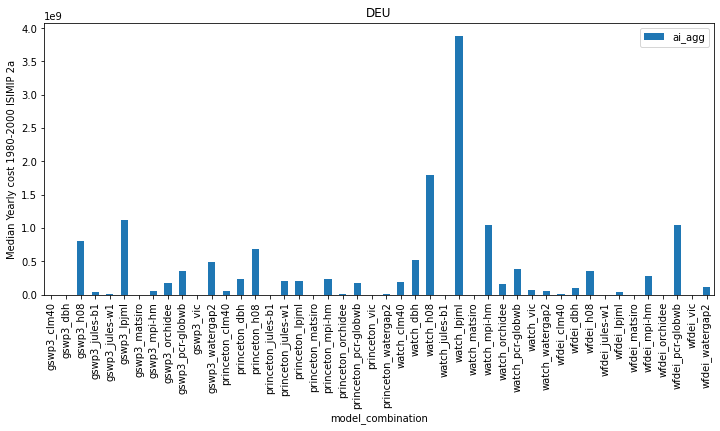

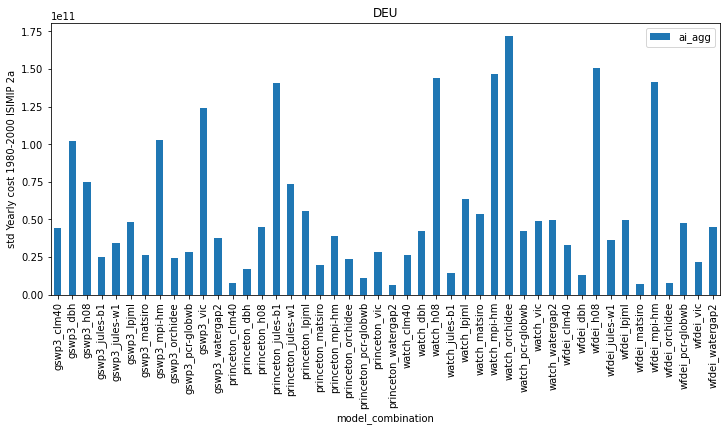

In [55]:
#Do the number for floods make sense?
plt.rcParams["figure.figsize"] = (12,5)

countries = ['DEU']
for country in countries:
    impact = Impact.from_csv(impact_csvs[country]['RF'])
    impact.imp_mat = impact.read_sparse_csr(impact_mats[country]['RF'])
    df = pd.DataFrame({'ai_agg': impact.at_event, 'event_name':impact.event_name})
    df = df['event_name'].str.split('_', expand=True).join(df)
    df = df.rename(columns={0:'year', 1:'hydro_model', 2:'climate_model'})
    #df['ai_agg'][df['ai_agg'] > 1e11] = np.nan
    df_median = df.groupby(['climate_model', 'hydro_model']).median().reset_index()
    df_std = df.groupby(['climate_model', 'hydro_model']).std().reset_index()


    df_median["model_combination"] = df_median["climate_model"] +'_'+ df_median["hydro_model"]
    df_std["model_combination"] = df_std["climate_model"] +'_'+ df_std["hydro_model"]


    df_median.plot.bar('model_combination', 'ai_agg', title=country)
    plt.ylabel("Median Yearly cost 1980-2000 ISIMIP 2a")
    
    
    df_std.plot.bar('model_combination', 'ai_agg', title=country)
    plt.ylabel("std Yearly cost 1980-2000 ISIMIP 2a")
    #plt.ylabel("Y axis label")


In [56]:
#sample events per year
def sample_events(impact, lam=1, years = np.array(range(1980,2000))):
    #create sampling vector
    events_per_year = yearsets.sample_from_poisson(len(np.array(range(1980,2000))), lam)
    sampling_vect = yearsets.sample_events(events_per_year, impact.frequency)
    impact_sample = yearsets.impact_from_sample(impact, years, sampling_vect)
    return impact_sample 

def make_yearset_country(country, csv, impact_mat, n_samples=10, years=np.array(range(1980,2000))):
    try:
        impact = Impact.from_csv(csv)
        impact.imp_mat = impact.read_sparse_csr(impact_mat)
    except:
        print("".join([" No data for ", str(country)]))
        return([])
    lam = np.sum(impact.frequency)
    lam = np.round(lam, 10)
    yearset_list = [sample_events(impact, lam=lam) for n in range(n_samples)]
    if yearset_list[0].imp_mat.shape[0]>len(np.array(range(1980,2000))):
        client =Client()
        exposures = client.get_litpop_default(country)
        yearset_list = [yearsets.aggregate_impact_to_year(yearset, exp=exposures) for yearset in yearset_list]
        
    return(yearset_list)
    

In [57]:
impacts_yearsets = {country:{hazard: make_yearset_country(country, impact_csvs[country][hazard], 
                                                  impact_mats[country][hazard]) for hazard in impact_csvs[country]} for country in impact_csvs}

/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 No data for DEU
 No data for VNM
 No data for COL


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_46678/406018701.py:11: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types.Specify dtype option on import or set low_memory=False.
  impact = Impact.from_csv(csv)


 No data for USA


In [58]:
#get impact for each year
def aai_dist(impacts_yearsets):
    if len(impacts_yearsets)>0:
        annual_impact_list = np.concatenate([impact.at_event for impact in impacts_yearsets])
        return annual_impact_list
    else:
        return [np.nan]   

    
## 300 year worst year event
def max_ai(impacts_yearsets):
    return(np.quantile(aai_dist(impacts_yearsets), 0.95))
 
def median_ai(impacts_yearsets):
    return(np.median(aai_dist(impacts_yearsets)))    

def mean_ai(impacts_yearsets):
    return(np.mean(aai_dist(impacts_yearsets)))    

In [59]:
max_cost_dict = {country: {hazard: max_ai(impacts_yearsets[country][hazard]) for hazard in impacts_yearsets[country]} for country in impacts_yearsets}

median_cost_dict = {country: {hazard: median_ai(impacts_yearsets[country][hazard]) for hazard in impacts_yearsets[country]} for country in impacts_yearsets}


mean_cost_dict = {country: {hazard: mean_ai(impacts_yearsets[country][hazard]) for hazard in impacts_yearsets[country]} for country in impacts_yearsets}



In [60]:
max_cost_dict['DEU']['RF']/1e9 #super high

181.3796089868553

In [61]:
annual_impact_list = {country: {hazard: aai_dist(impacts_yearsets[country][hazard]) for hazard in impacts_yearsets[country]} for country in impacts_yearsets}


In [62]:
np.median(annual_impact_list['TWN']['RF'])

7005190572.804903

In [63]:
aai_dist_array = aai_dist(impacts_yearsets['DEU']['RF'])

(array([179.,   7.,  10.,   2.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00000000e+00, 6.78786123e+10, 1.35757225e+11, 2.03635837e+11,
        2.71514449e+11, 3.39393062e+11, 4.07271674e+11, 4.75150286e+11,
        5.43028898e+11, 6.10907511e+11, 6.78786123e+11]),
 <BarContainer object of 10 artists>)

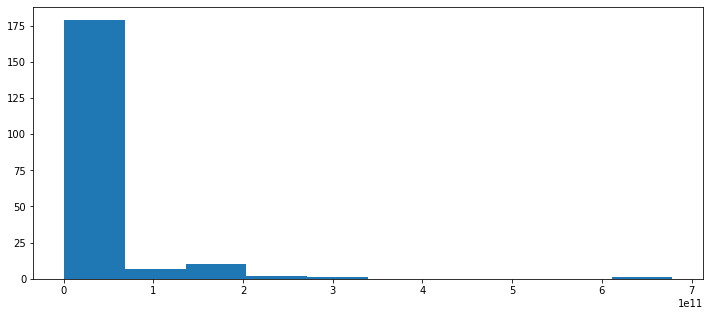

In [64]:
plt.hist(annual_impact_list['DEU']['RF'])

(array([31., 31., 23., 50., 35.,  7.,  8.,  9.,  5.,  1.]),
 array([4.65778420e+09, 5.34975790e+09, 6.04173161e+09, 6.73370531e+09,
        7.42567902e+09, 8.11765273e+09, 8.80962643e+09, 9.50160014e+09,
        1.01935738e+10, 1.08855476e+10, 1.15775213e+10]),
 <BarContainer object of 10 artists>)

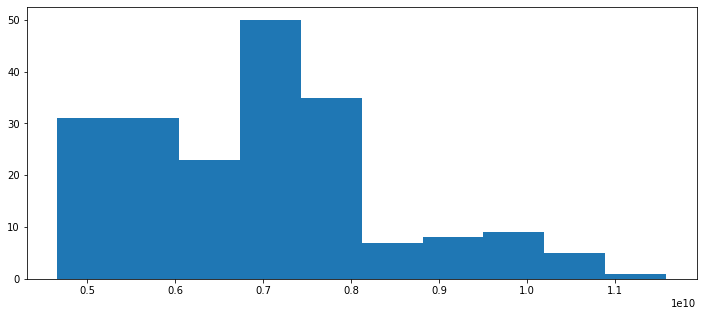

In [65]:
plt.hist(annual_impact_list['TWN']['RF'])

Text(0.5, 1.0, 'TWN')

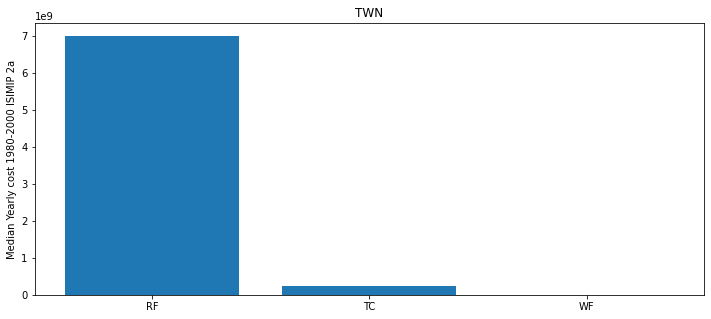

In [67]:
plt.bar(median_cost_dict['TWN'].keys(), median_cost_dict['TWN'].values())
plt.ylabel('Median Yearly cost 1980-2000 ISIMIP 2a')
plt.title('TWN')

Text(0.5, 1.0, 'DEU')

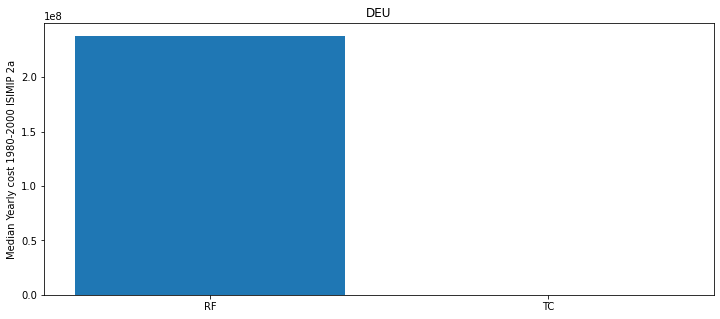

In [68]:
plt.bar(median_cost_dict['DEU'].keys(), median_cost_dict['DEU'].values())

plt.ylabel("Median Yearly cost 1980-2000 ISIMIP 2a")

plt.title('DEU')


Text(0.5, 1.0, 'USA')

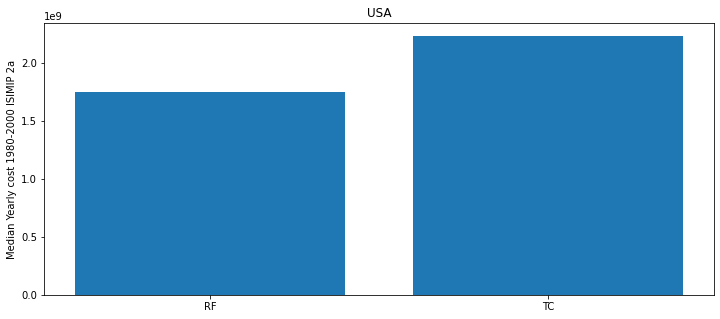

In [69]:
plt.bar(median_cost_dict['USA'].keys(), median_cost_dict['USA'].values())

plt.ylabel("Median Yearly cost 1980-2000 ISIMIP 2a")

plt.title('USA')

In [70]:
# calculate average cost per grid point
def median_total_cost_gridpoint(impacts_yearsets, country):
    median_cost = np.median([impact.imp_mat.sum(axis=0) for impact in impacts_yearsets], axis=0)
    return median_cost

In [71]:
 def calc_relative_cost_gridpoint(median_cost, country, years):
    client = Client()
    litpop = client.get_litpop_default(country)
    relative_cost = median_cost.flatten()/(litpop.gdf.value.replace(0,1)* years)
    return relative_cost

In [72]:
#calculate average cost per grid point for each country
median_total_cost_gridpoint_dict = {country: {hazard: median_total_cost_gridpoint(impacts_yearsets[country][hazard], country) for hazard in impacts_yearsets[country]} for country in impacts_yearsets}


/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [73]:
median_relative_cost_gridpoint_dict = {country: {hazard: calc_relative_cost_gridpoint(median_total_cost_gridpoint_dict[country][hazard], country, 20) for hazard in median_total_cost_gridpoint_dict[country]} for country in median_total_cost_gridpoint_dict}


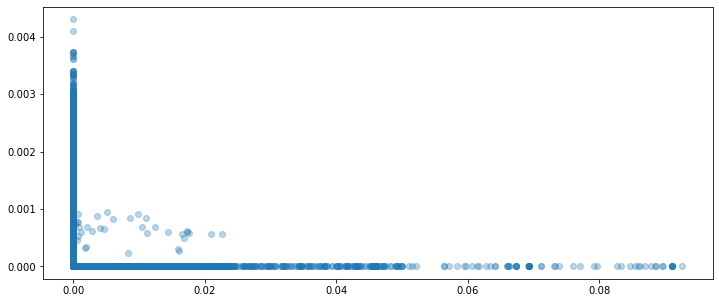

In [83]:
plt.scatter(median_relative_cost_gridpoint_dict['USA']['RF'], median_relative_cost_gridpoint_dict['USA']['TC'], alpha=0.3)

In [76]:
len(median_relative_cost_gridpoint_dict['USA']['TC'][median_relative_cost_gridpoint_dict['USA']['TC']>0])/len(median_relative_cost_gridpoint_dict['USA']['TC'])*100

9.058480887079593

In [77]:
len(median_relative_cost_gridpoint_dict['USA']['RF'][median_relative_cost_gridpoint_dict['USA']['RF']>0])/len(median_relative_cost_gridpoint_dict['USA']['RF'])*100

0.323122878437068

many more places seem to be hit by tc, but flood impacts are much higher when they happen (7.7% vs 0.24%)

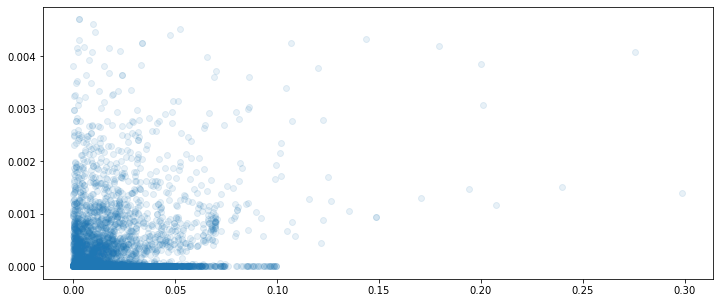

In [84]:
plt.scatter(median_relative_cost_gridpoint_dict['VNM']['RF'][median_relative_cost_gridpoint_dict['VNM']['RF']>0], median_relative_cost_gridpoint_dict['VNM']['TC'][median_relative_cost_gridpoint_dict['VNM']['RF']>0], alpha=0.1)

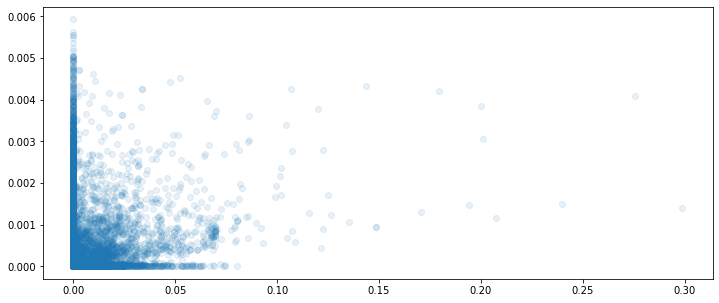

In [85]:
plt.scatter(median_relative_cost_gridpoint_dict['VNM']['RF'][median_relative_cost_gridpoint_dict['VNM']['TC']>0], median_relative_cost_gridpoint_dict['VNM']['TC'][median_relative_cost_gridpoint_dict['VNM']['TC']>0], alpha=0.1)

In [79]:
print(len(median_relative_cost_gridpoint_dict['VNM']['TC'][median_relative_cost_gridpoint_dict['VNM']['TC']>0])/len(median_relative_cost_gridpoint_dict['VNM']['TC'])*100)
print(len(median_relative_cost_gridpoint_dict['VNM']['RF'][median_relative_cost_gridpoint_dict['VNM']['RF']>0])/len(median_relative_cost_gridpoint_dict['VNM']['RF'])*100)

65.60402684563759
32.3328361918966


In [80]:
print(len(median_relative_cost_gridpoint_dict['TWN']['TC'][median_relative_cost_gridpoint_dict['TWN']['TC']>0])/len(median_relative_cost_gridpoint_dict['TWN']['TC'])*100)
print(len(median_relative_cost_gridpoint_dict['TWN']['RF'][median_relative_cost_gridpoint_dict['TWN']['RF']>0])/len(median_relative_cost_gridpoint_dict['TWN']['RF'])*100)

99.89200863930886
2.591792656587473
